# Ticket Escalation Risk (Simple AI Model)

Goal: predict if a new support ticket will be a **slow ticket**.

Because this dataset doesn’t really have 48-hour resolution times, we define:
**Slow ticket = slowest 25% of tickets** (top quartile).


Imports + load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/customer_support_tickets.csv")
print("Loaded:", df.shape)
df.head(3)


Loaded: (8469, 17)


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0


## Step 1 — Create the label (slow ticket)

We create `hours_to_resolution` from timestamps, then define:

- slow ticket = top 25% longest tickets  
- label `y`:
  - `1` = slow
  - `0` = not slow


Compute hours + label

In [2]:
start = pd.to_datetime(df["First Response Time"], errors="coerce", utc=True)
end = pd.to_datetime(df["Time to Resolution"], errors="coerce", utc=True)

hours = (end - start).dt.total_seconds() / 3600.0

# Fix overnight wrap-around:
# example: first response at 16:00, resolution at 01:00 -> likely next day
hours = hours.where(hours >= 0, hours + 24)

mask = ~hours.isna()
df2 = df.loc[mask].copy()
h2 = hours.loc[mask].copy()

threshold = float(np.percentile(h2, 75))  # slowest 25%
y = (h2 > threshold).astype(int)

print("Tickets used:", len(y))
print("Slow threshold (hours):", round(threshold, 2))
print("Slow ticket rate:", round(float(y.mean()), 3))


Tickets used: 2769
Slow threshold (hours): 17.95
Slow ticket rate: 0.25


Plot the hours distribution

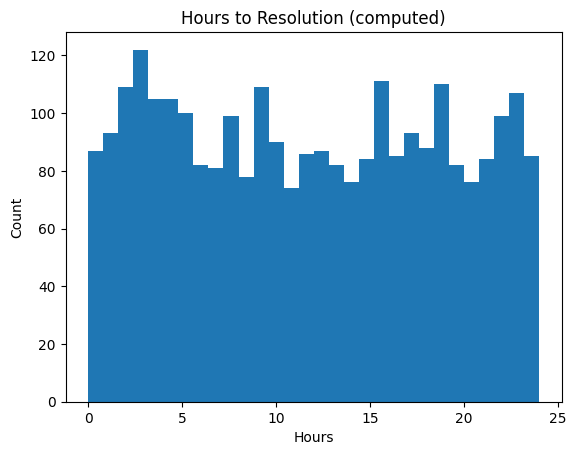

In [3]:
plt.figure()
plt.hist(h2, bins=30)
plt.title("Hours to Resolution (computed)")
plt.xlabel("Hours")
plt.ylabel("Count")
plt.show()


## Step 2 — Build features (no cheating)

We use only stuff known when the ticket is created:
- Subject + Description (text)
- Ticket Type / Priority / Channel / Product Purchased

We do NOT use:
- Resolution text
- Ticket status
- Satisfaction rating
- Resolution timestamps (those are only for making the label)


Build X

In [4]:
df2["text"] = (df2["Ticket Subject"].fillna("") + " " + df2["Ticket Description"].fillna("")).str.strip()

X = df2[[
    "Ticket Type",
    "Ticket Priority",
    "Ticket Channel",
    "Product Purchased",
    "text"
]].copy()

X.head(3)


,Ticket Type,Ticket Priority,Ticket Channel,Product Purchased,text
2,Technical issue,Low,Social media,Dell XPS,Network problem I'm facing a problem with my {...
3,Billing inquiry,Low,Social media,Microsoft Office,Account access I'm having an issue with the {p...
4,Billing inquiry,Low,Email,Autodesk AutoCAD,Data loss I'm having an issue with the {produc...


## Step 3 — Split the data

We train on 80% and test on 20%.


Train/test split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (2215, 5) Test: (554, 5)


## Step 4A — Baseline model (Logistic Regression)

This is a simple model that gives a risk score.
No “epochs” here. We just use it as a baseline.


Baseline pipeline + train + evaluate

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

def to_text_1d(x):
    if isinstance(x, pd.DataFrame):
        s = x.iloc[:, 0]
    else:
        s = pd.Series(x)
    return s.fillna("").astype(str).to_numpy()

text_pipe = Pipeline([
    ("to_text", FunctionTransformer(to_text_1d, validate=False)),
    ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2)),
])

cat_pipe = OneHotEncoder(handle_unknown="ignore")

prep = ColumnTransformer(
    transformers=[
        ("text", text_pipe, "text"),
        ("cat", cat_pipe, ["Ticket Type", "Ticket Priority", "Ticket Channel", "Product Purchased"]),
    ],
    remainder="drop"
)

baseline = Pipeline([
    ("prep", prep),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

baseline.fit(X_train, y_train)

probs_base = baseline.predict_proba(X_test)[:, 1]
print("Baseline ROC-AUC:", round(roc_auc_score(y_test, probs_base), 3))
print("Baseline PR-AUC:", round(average_precision_score(y_test, probs_base), 3))


Baseline ROC-AUC: 0.477
Baseline PR-AUC: 0.232


## Step 4B — Neural net model (with epochs + loss)

This model trains in **epochs**.
1 epoch = one full pass through the training data.

We will plot:
- training loss per epoch
- (optional) validation score over epochs


Neural net pipeline (SVD -> MLP)

In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

nn = Pipeline([
    ("prep", prep),
    ("svd", TruncatedSVD(n_components=200, random_state=42)),
    ("scale", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        max_iter=30,          # THIS is basically epochs
        early_stopping=True,  # creates a validation split internally
        random_state=42
    ))
])

nn.fit(X_train, y_train)

probs_nn = nn.predict_proba(X_test)[:, 1]
print("NN ROC-AUC:", round(roc_auc_score(y_test, probs_nn), 3))
print("NN PR-AUC:", round(average_precision_score(y_test, probs_nn), 3))


NN ROC-AUC: 0.464
NN PR-AUC: 0.231


Plot loss curve (epochs)

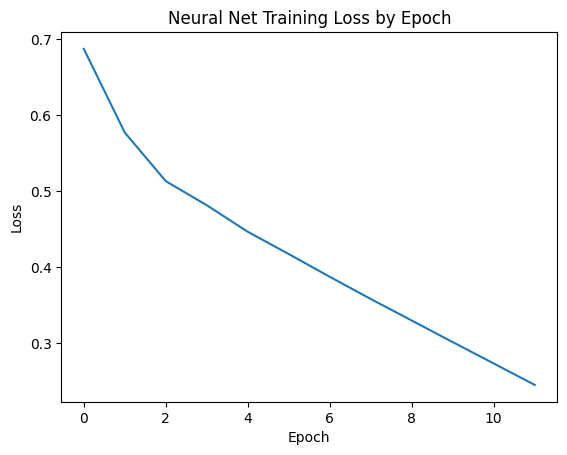

Epochs trained: 12


In [8]:
mlp = nn.named_steps["clf"]

plt.figure()
plt.plot(mlp.loss_curve_)
plt.title("Neural Net Training Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

print("Epochs trained:", len(mlp.loss_curve_))


Plot validation score (if early stopping)

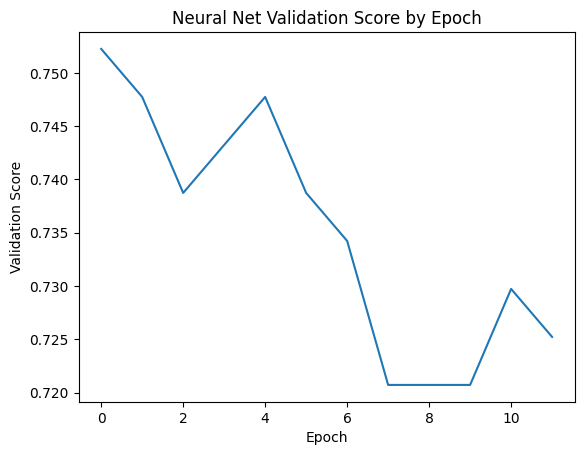

In [9]:
# This exists when early_stopping=True
if hasattr(mlp, "validation_scores_"):
    plt.figure()
    plt.plot(mlp.validation_scores_)
    plt.title("Neural Net Validation Score by Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Score")
    plt.show()
else:
    print("No validation_scores_ found (early_stopping might be off).")


“Escalation” view (top 10%)

In [10]:
def topk_recall(y_true, scores, frac=0.10):
    k = max(1, int(frac * len(y_true)))
    idx = np.argsort(scores)[::-1][:k]
    return float(y_true.iloc[idx].sum() / max(1, y_true.sum())), k

r10_base, k_base = topk_recall(y_test, probs_base, 0.10)
r10_nn, k_nn = topk_recall(y_test, probs_nn, 0.10)

print(f"Baseline: top10% (k={k_base}) recall:", round(r10_base, 3))
print(f"NN:       top10% (k={k_nn}) recall:", round(r10_nn, 3))


Baseline: top10% (k=55) recall: 0.087
NN:       top10% (k=55) recall: 0.08


## Wrap-up

What we did:
- created a clear label (slow ticket = top 25%)
- trained a baseline model
- trained a neural net model with epochs + loss curve
- evaluated using ROC-AUC, PR-AUC, and top-10% escalation recall


## Results (this run)

**Data used**
- Tickets used (had timestamps): 2769
- Label: slow ticket = top 25% by time-to-resolve
- Slow threshold: 17.95 hours
- Slow ticket rate: 0.25

**Baseline model (Logistic Regression)**
- ROC-AUC: 0.477
- PR-AUC: 0.232
- Escalation view (top 10% highest risk): recall = 0.087

**Neural net model (MLP)**
- Epochs trained: 12
- ROC-AUC: 0.464
- PR-AUC: 0.231
- Escalation view (top 10% highest risk): recall = 0.080

**Takeaway**
The baseline model performed slightly better than the neural net on this dataset.
